#### Packages

In [1]:
# basic
import pandas as pd
import numpy as np
import datetime as dt
from functools import reduce

# SQL
from dotenv import load_dotenv
import os
from sqlalchemy import create_engine

# sklearn
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.datasets import fetch_dataset
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor

# Tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
import tensorflow as tf

# scikeras
from scikeras.wrappers import KerasRegressor

# Stationary Tests
from statsmodels.tsa.stattools import adfuller,kpss

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt

from datetime import datetime
from dateutil.relativedelta import relativedelta

end_date = 1
market=1

---

#### Functions

In [2]:
# Define function to create lagged features (shifted price, rolling mean, standard deviation, maximum and minimum) for the price
def create_hour_lags(df, target_column, lags):
    df_c = df.copy()
    for lag in lags:
        df_c.loc[:, f'{target_column}_{lag}_lag'] = df_c[target_column].shift(lag)
        #df_c.loc[:, f'{target_column}_{lag}_mean'] = df_c[target_column].rolling(lag).mean()
        #df_c.loc[:, f'{target_column}_{lag}_std'] = df_c[target_column].rolling(lag).std()
        #df_c.loc[:, f'{target_column}_{lag}_max'] = df_c[target_column].rolling(lag).max()
        #df_c.loc[:, f'{target_column}_{lag}_min'] = df_c[target_column].rolling(lag).min()
    return df_c

In [3]:
# Define function to create lagged features that will be used as predictors (timestamp shifted to merge with weather predictors)
def create_new_predictors_hour_lags(df, target_column, lags):
    df_c = df.copy()
    for lag in lags:
        df_c.loc[:, f'{target_column}_{lag}_lag'] = df_c[target_column].shift(lag)
        #df_c.loc[:, f'{target_column}_{lag}_mean'] = df_c[target_column].rolling(lag).mean()
        #df_c.loc[:, f'{target_column}_{lag}_std'] = df_c[target_column].rolling(lag).std()
        #df_c.loc[:, f'{target_column}_{lag}_max'] = df_c[target_column].rolling(lag).max()
        #df_c.loc[:, f'{target_column}_{lag}_min'] = df_c[target_column].rolling(lag).min()
    df_c.loc[df_c.index[-1], 'timestamp'] = df_c['timestamp'].iloc[-1] + pd.Timedelta(hours=1)
    return df_c[-1:]

In [4]:
# Create prediction function
def predict_72h(start_df, future_df, predictor_vars, target_column, datetime, model, lags):
    """
    Predicts a target variable hourly into the future for 72 hours.

    Parameters:
    - start_df: Dataframe, the data that is needed to create the lagged features (can be the training data or a slice of it, must include target variable)
    - future_df: Dataframe, the same features as in the start_df minus the target variable, with values for the next 72 hours
    - predictor_vars: list, the variables in the dataframe that are predictors 
    - target_column: string, the name of the variable that is supposed to be predicted
    - datetime: string, the name of the datetime variable 
    - model: a pretrained model that is used for the predictions
    - lags: list, the values for the hours of lags

    Returns:
    - predictions: list, 72 values that represent the predictions for the future values of the target variable
    """
    
    # Create empty predictions list
    predictions = []

    # Make copies of dataframes:
    start_df_c = start_df
    future_df_c = future_df

    # Iniate loop
    for i in range(0, 72):

        # Create dataframe with weather predictor for the unseen value
        pred1 = future_df_c[predictor_vars][i:i+1]

        # Create dataframe with lagged predictors for first unseen value
        pred2 = create_new_predictors_hour_lags(start_df_c, target_column=target_column, lags=lags)
        # Combine predictor dataframes into final predictor
        cols = [col for col in pred2.columns if col not in pred1.columns or col == datetime]
        pred2_f = pred2[cols]
        predictors = pd.merge(pred1, pred2_f, on=datetime, how='left')

        # Make prediction
        y = model.predict(predictors.drop(columns=[target_column, datetime]))

        # Add prediction to prediction list
        predictions.append(y)

        # Combine prediction with predictors to new dataframe with same features as start_df
        pred1[target_column] = y
        cols2 = pred1.columns.tolist()
        new_cols_order = cols2[:1] + [target_column] + cols2[1:-1] 
        appendage = pred1[new_cols_order]
        
        # Add new row to dataframe to be ready to start again
        start_df_c = pd.concat([start_df_c, appendage], axis=0, ignore_index=True)

    return predictions  
    

In [5]:
def create_lagged_df(df, target='price_eur_mwh', lags=[24, 48, 72]):
    """
    Create a new DataFrame with lagged values for specified intervals.
    
    Parameters:
    - df: pd.DataFrame, the original DataFrame with 'timestamp' and variables.
    - lags: list, list of lag intervals (in hours).
    
    Returns:
    - pd.DataFrame, a new DataFrame with 'timestamp' and lagged variables.
    """
    
    # Initialize the new DataFrame with the timestamp
    new_df = df[['timestamp']].copy()
    
    # Create lagged features
    for col in df.columns:
        if col != 'timestamp':
            for lag in lags:
                new_df[f'{col}_lag_{lag}h'] = df[col].shift(lag)

    # Reset index to bring 'timestamp' back as a column
    new_df = new_df.reset_index(drop=True)
    
    return new_df

---

#### Data

In [6]:
# Load environment variables from .env file
load_dotenv()

# Get database connection parameters from environment variables
db_name = os.getenv('DB_NAME')
db_user = os.getenv('DB_USER')
db_password = os.getenv('DB_PASSWORD')
db_host = os.getenv('DB_HOST')
db_port = os.getenv('DB_PORT')

# Create the database URL
db_url = f"postgresql://{db_user}:{db_password}@{db_host}:{db_port}/{db_name}"

# Create an engine
engine = create_engine(db_url)

# Define your queries -> set your table name here
query1 = 'SELECT * FROM "02_silver"."fact_full_weather_region"'
query2 = 'SELECT * FROM "03_gold"."fact_electricity_market_germany"'

# Execute the query and load the data into a pandas DataFrame
weather = pd.read_sql(query1, engine).sort_values(by='timestamp').reset_index(drop=True)
gold = pd.read_sql(query2, engine).sort_values(by='timestamp').reset_index(drop=True)

In [7]:
market = gold.drop(columns=['temperature_2m', 'relative_humidity_2m', 'apparent_temperature', 'precipitation', 'cloud_cover', 'wind_speed_10m', 
                            'wind_direction_10m', 'direct_radiation', 'diffuse_radiation', 'sunshine_duration', 'date', 'time'])

In [8]:
# Deal with outliers in the price data
market.loc[market['price_eur_mwh'] < -200, 'price_eur_mwh'] = np.nan

# Replace NAs by imputation
market['price_eur_mwh'] = market['price_eur_mwh'].interpolate()

In [9]:
# Drop forecast column
weather = weather.drop(columns='is_forecast')

In [10]:
# Pivot weather data
weather = weather.pivot(index='timestamp', columns='region')

# Flatten the column multi-index
weather.columns = [f'{col[0]}_{col[1]}' for col in weather.columns]

# Reset the index to convert the timestamp from the index back to a column
weather = weather.reset_index()

In [84]:
# Set end date for last known price
end_date = market['timestamp'].max()

# Create a new DataFrame for the next 72 hours
future_timestamps = pd.date_range(start=end_date + pd.Timedelta(hours=1), periods=72, freq='h')
future_df = pd.DataFrame({'timestamp': future_timestamps})

In [12]:
# Add future_df to market to create lags
market_lag = pd.concat([market, future_df], axis=0, ignore_index=True)

# Create dataframe with lags of the power data
lagged_market = create_lagged_df(market_lag)

In [13]:
# For 24h forecast:
lagged_market_24 = pd.merge(lagged_market.dropna(), market[['timestamp', 'price_eur_mwh']], on='timestamp', how='left')

# For 48h forecast:
columns_to_keep_48 = [col for col in lagged_market.columns if col.endswith('_48h') or col.endswith('_72h')]
columns_to_keep_48 = ['timestamp'] + columns_to_keep_48
lagged_market_48 = pd.merge(lagged_market[columns_to_keep_48].dropna(), market[['timestamp', 'price_eur_mwh']], on='timestamp', how='left')

# For 72h forecast:
columns_to_keep_72 = [col for col in lagged_market.columns if col.endswith('_72h')]
columns_to_keep_72 = ['timestamp'] + columns_to_keep_72
lagged_market_72 = pd.merge(lagged_market[columns_to_keep_72].dropna(), market[['timestamp', 'price_eur_mwh']], on='timestamp', how='left')

---

### First Tests: 6 Month Training Window (24h prediction)

In [85]:
# for evaluation purposes, we predict three days earlier than the last known price
end_date_adj = end_date - relativedelta(days=3)

In [87]:
end_date_adj

Timestamp('2024-07-12 07:00:00+0000', tz='UTC')

In [88]:
lagged_market_24_adj = lagged_market_24[lagged_market_24['timestamp'] <= end_date_adj + relativedelta(days=1)]
lagged_market_48_adj = lagged_market_48[lagged_market_48['timestamp'] <= end_date_adj + relativedelta(days=2)]
lagged_market_72_adj = lagged_market_72[lagged_market_72['timestamp'] <= end_date_adj + relativedelta(days=3)]

In [89]:
test0 = pd.merge(lagged_market_24_adj, weather, on='timestamp', how='left')

In [77]:
def train_test(df, datetime='timestamp', target='price_eur_mwh', months=6, enddate=end_date):
    startdate = enddate - relativedelta(months=6)
    x0 = df[(df[datetime] < enddate) & (df[datetime] >= startdate)]
    X_train = x0.drop([target, datetime], axis=1)
    y_train = x0[target]
    X_test = df[df[datetime] > enddate].drop([target, datetime], axis=1)
    return X_train, y_train, X_test

In [97]:
X_train_24_0, y_train_24_0, X_test_24_0 = train_test(test0, enddate=end_date_adj)

In [98]:
# LSTM Predictions
def lstm_pred(X_train, y_train, X_test):
    # Normalize the data
    scaler_X = MinMaxScaler()
    scaler_y = MinMaxScaler()
    X_train_scaled = scaler_X.fit_transform(X_train)
    X_test_scaled = scaler_X.transform(X_test)
    y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1))

    # Reshape data for LSTM [samples, time steps, features]
    X_train_scaled = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
    X_test_scaled = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

    # Build the model
    model = Sequential()
    model.add(Bidirectional(LSTM(150, activation='relu', return_sequences=True), input_shape=(X_train_scaled.shape[1], X_train_scaled.shape[2])))
    model.add(LSTM(150, activation='relu', return_sequences=True))
    model.add(LSTM(150, activation='relu', return_sequences=True))
    model.add(LSTM(150, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    model.fit(X_train_scaled, y_train_scaled, epochs=70, batch_size=16, verbose=0)

    # Make prediction
    y_pred_test_scaled = model.predict(X_test_scaled)
    y_pred_test = scaler_y.inverse_transform(y_pred_test_scaled).flatten()
    return y_pred_test

In [99]:
pred_0 = lstm_pred(X_train_24_0, y_train_24_0, X_test_24_0)

c:\Users\Jakob\Documents\neuefische\capstone_project\.venv\Lib\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 639ms/step


In [81]:
def evaluate_pred(pred, df=market, datetime='timestamp', target='price_eur_mwh', enddate=end_date, hours=24, return_next=False):
    # Find the index of the row corresponding to enddate
    enddate_index = df[df[datetime] == enddate].index[0]

    # Select the next n rows after enddate_index
    next_values = df.loc[enddate_index + 1:enddate_index + hours, target]
    
    mae = mean_absolute_error(next_values, pred)
    if return_next==False:
        print('The mean absolute error is:')
        return mae
    else:
        return mae, next_values

In [101]:
mae0, next = evaluate_pred(pred_0, enddate=end_date_adj, return_next=True)
mae0

33.78602488180002

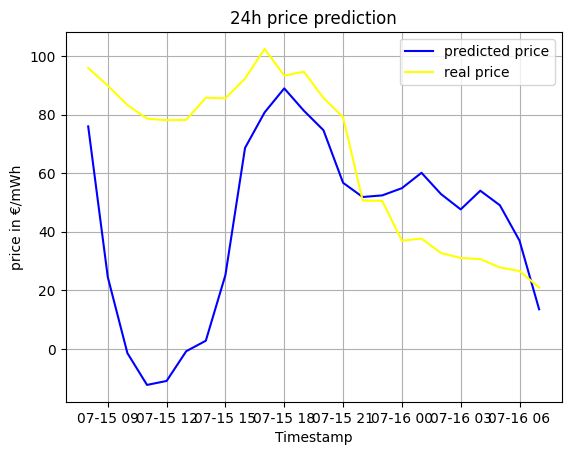

In [ ]:
plt.plot(pd.date_range(start=end_date_adj + pd.Timedelta(hours=1), periods=24, freq='h'), pred_0, label='predicted price', color='blue')
plt.plot(pd.date_range(start=end_date_adj + pd.Timedelta(hours=1), periods=24, freq='h'), next, label='real price', color='yellow')

# Adding labels and title
plt.xlabel('Timestamp')
plt.ylabel('price in €/mWh')
plt.title('24h price prediction')
plt.legend()

# Displaying the plot
plt.grid(True)
plt.show()

---

#### Time Variables: Numeric or Dummy

To be able to test the prediction, the end date will be set to 24 hours before the last known price

In [104]:
# df copy for first test
t1_24h = lagged_market_24_adj.copy()

In [105]:
# Add numeric time variables
t1_24h['hour'] = t1_24h['timestamp'].dt.hour
t1_24h['dayofweek'] = t1_24h['timestamp'].dt.dayofweek
t1_24h['is_weekend'] = t1_24h['dayofweek'].isin([5, 6]).astype(int)
t1_24h['month'] = t1_24h['timestamp'].dt.month

In [106]:
test1 = pd.merge(t1_24h, weather, on='timestamp', how='left')

In [107]:
X_train_24_1, y_train_24_1, X_test_24_1 = train_test(test1, enddate=end_date_adj)

In [108]:
pred_t1 = lstm_pred(X_train_24_1, y_train_24_1, X_test_24_1)

c:\Users\Jakob\Documents\neuefische\capstone_project\.venv\Lib\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 633ms/step


In [109]:
mae1, next = evaluate_pred(pred_t1, enddate=end_date_adj, return_next=True)
mae1

25.175597146352132

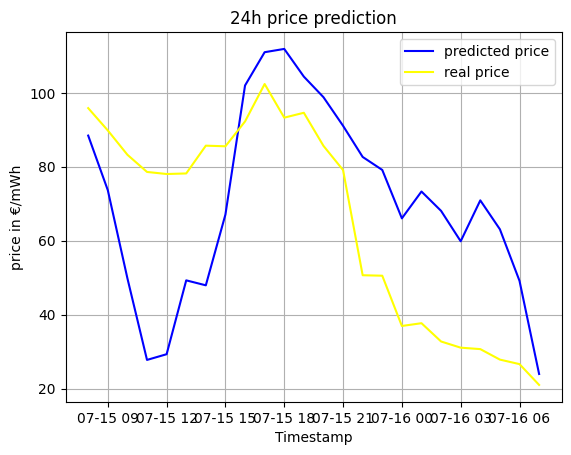

In [110]:
plt.plot(pd.date_range(start=end_date + pd.Timedelta(hours=1), periods=24, freq='h'), pred_t1, label='predicted price', color='blue')
plt.plot(pd.date_range(start=end_date + pd.Timedelta(hours=1), periods=24, freq='h'), next, label='real price', color='yellow')

# Adding labels and title
plt.xlabel('Timestamp')
plt.ylabel('price in €/mWh')
plt.title('24h price prediction')
plt.legend()

# Displaying the plot
plt.grid(True)
plt.show()

##### 12 months window

In [111]:
X_train_24_2, y_train_24_2, X_test_24_2 = train_test(t1_24h, enddate=end_date_adj, months=12)
pred_t2 = lstm_pred(X_train_24_2, y_train_24_2, X_test_24_2)

c:\Users\Jakob\Documents\neuefische\capstone_project\.venv\Lib\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 629ms/step


In [112]:
mae, next = evaluate_pred(pred_t2, return_next=True, enddate=end_date_adj)
mae

46.88509699920814

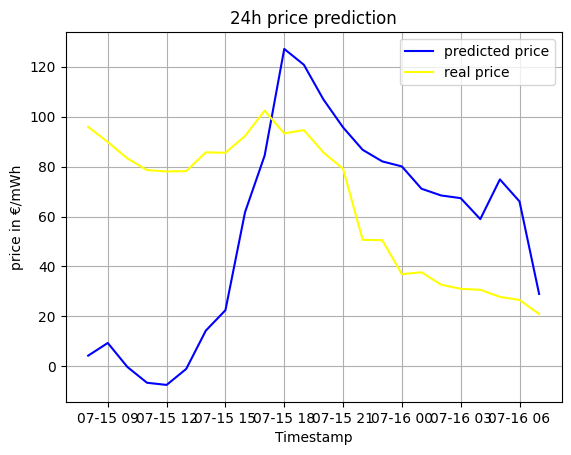

In [113]:
plt.plot(pd.date_range(start=end_date + pd.Timedelta(hours=1), periods=24, freq='h'), pred_t2, label='predicted price', color='blue')
plt.plot(pd.date_range(start=end_date + pd.Timedelta(hours=1), periods=24, freq='h'), next, label='real price', color='yellow')

# Adding labels and title
plt.xlabel('Timestamp')
plt.ylabel('price in €/mWh')
plt.title('24h price prediction')
plt.legend()

# Displaying the plot
plt.grid(True)
plt.show()

##### Dummies

In [114]:
t2_24h_0 = t1_24h.copy()

In [115]:
def map_month_to_summer(month):
    if month in [7, 8, 9]:
        return 1
    else:
        return 0

def map_month_to_winter(month):
    if month in [11, 12]:
        return 1
    else:
        return 0
    
def map_day_to_saturday(day):
    if day == 5:
        return 1
    else:
        return 0
    
def map_day_to_sunday(day):
    if day == 6:
        return 1
    else:
        return 0
    
def map_hour_to_daypart(hour):
    if hour in [22, 23, 0, 1, 2, 3]:
        return 'night'
    elif hour in [4, 5, 6, 7, 8, 9]:
        return 'morning'
    elif hour in [10, 11, 12, 13, 14]:
        return 'day'
    else:
        return 'evening'

# Apply the function to create the 'season' column
t2_24h_0['summer'] = t2_24h_0['month'].apply(map_month_to_summer)
t2_24h_0['winter'] = t2_24h_0['month'].apply(map_month_to_winter)
t2_24h_0['saturday'] = t2_24h_0['dayofweek'].apply(map_day_to_saturday)
t2_24h_0['sunday'] = t2_24h_0['dayofweek'].apply(map_day_to_sunday)
t2_24h_0['daypart'] = t2_24h_0['hour'].apply(map_hour_to_daypart)

# Create daypart dummies
daypart_dummies = pd.get_dummies(t2_24h_0['daypart'], prefix='daypart')
t2_24h_d = pd.concat([t2_24h_0, daypart_dummies], axis=1)

# drop columns
t2_24h = t2_24h_d.drop(columns=['hour', 'dayofweek', 'is_weekend', 'month', 'daypart'])

In [116]:
X_train_24_3, y_train_24_3, X_test_24_3 = train_test(t2_24h, months=6, enddate=end_date_adj)
pred_t3 = lstm_pred(X_train_24_3, y_train_24_3, X_test_24_3)

c:\Users\Jakob\Documents\neuefische\capstone_project\.venv\Lib\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 678ms/step


In [117]:
mae3, next3 = evaluate_pred(pred_t3, return_next=True, enddate=end_date_adj)
mae3

35.40074949681759

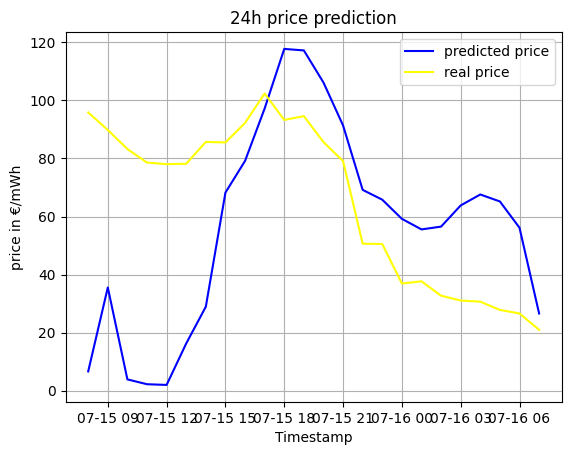

In [118]:
plt.plot(pd.date_range(start=end_date + pd.Timedelta(hours=1), periods=24, freq='h'), pred_t3, label='predicted price', color='blue')
plt.plot(pd.date_range(start=end_date + pd.Timedelta(hours=1), periods=24, freq='h'), next3, label='real price', color='yellow')

# Adding labels and title
plt.xlabel('Timestamp')
plt.ylabel('price in €/mWh')
plt.title('24h price prediction')
plt.legend()

# Displaying the plot
plt.grid(True)
plt.show()

---

#### 48 hour prediction


In [123]:
# df copy for first test
t1_48h = lagged_market_48_adj.copy()

# Add numeric time variables
t1_48h['hour'] = t1_48h['timestamp'].dt.hour
t1_48h['dayofweek'] = t1_48h['timestamp'].dt.dayofweek
t1_48h['is_weekend'] = t1_48h['dayofweek'].isin([5, 6]).astype(int)
t1_48h['month'] = t1_48h['timestamp'].dt.month

In [124]:
X_train_48_1, y_train_48_1, X_test_48_1 = train_test(t1_48h, months=6, enddate=end_date_adj)
pred_48_1 = lstm_pred(X_train_48_1, y_train_48_1, X_test_48_1)

c:\Users\Jakob\Documents\neuefische\capstone_project\.venv\Lib\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 584ms/step


In [125]:
mae4, next4 = evaluate_pred(pred_48_1, hours=48, return_next=True, enddate=end_date_adj)
mae4

32.8435476599137

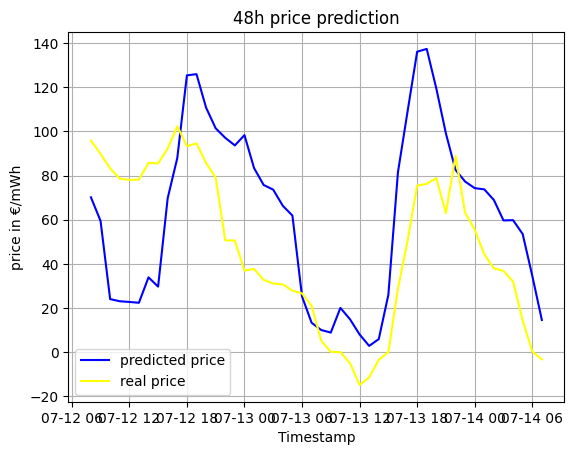

In [126]:
plt.plot(pd.date_range(start=end_date_adj + pd.Timedelta(hours=1), periods=48, freq='h'), pred_48_1, label='predicted price', color='blue')
plt.plot(pd.date_range(start=end_date_adj + pd.Timedelta(hours=1), periods=48, freq='h'), next4, label='real price', color='yellow')

# Adding labels and title
plt.xlabel('Timestamp')
plt.ylabel('price in €/mWh')
plt.title('48h price prediction')
plt.legend()

# Displaying the plot
plt.grid(True)
plt.show()

#### 72h prediction

In [127]:
# df copy for first test
t1_72h = lagged_market_72_adj.copy()

# Add numeric time variables
t1_72h['hour'] = t1_72h['timestamp'].dt.hour
t1_72h['dayofweek'] = t1_72h['timestamp'].dt.dayofweek
t1_72h['is_weekend'] = t1_72h['dayofweek'].isin([5, 6]).astype(int)
t1_72h['month'] = t1_72h['timestamp'].dt.month

In [128]:
X_train_72_1, y_train_72_1, X_test_72_1 = train_test(t1_72h, months=6, enddate=end_date_adj)
pred_72_1 = lstm_pred(X_train_72_1, y_train_72_1, X_test_72_1)

c:\Users\Jakob\Documents\neuefische\capstone_project\.venv\Lib\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 277ms/step


In [129]:
mae5, next5 = evaluate_pred(pred_72_1, hours=72, return_next=True, enddate=end_date_adj)
mae5

25.215010630596016

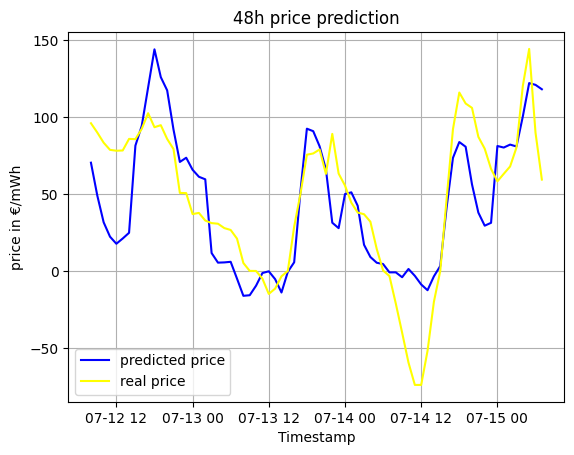

In [130]:
plt.plot(pd.date_range(start=end_date_adj + pd.Timedelta(hours=1), periods=72, freq='h'), pred_72_1, label='predicted price', color='blue')
plt.plot(pd.date_range(start=end_date_adj + pd.Timedelta(hours=1), periods=72, freq='h'), next5, label='real price', color='yellow')

# Adding labels and title
plt.xlabel('Timestamp')
plt.ylabel('price in €/mWh')
plt.title('48h price prediction')
plt.legend()

# Displaying the plot
plt.grid(True)
plt.show()